In [42]:
#import required libraries
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from optbinning import BinningProcess
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import skexplain
import shap

In [3]:
#load in data
data = pd.read_csv("rolling_average_differentials.csv")

#randomly sample an outcome from each game
data = data.groupby("game_id").sample(n=1, random_state=84)

#filter for only stats variables and the target variable
data = data.iloc[:, 4:]
data.head()

,scores,passing_yards,rushing_yards,passing_touchdown,rushing_touchdown,highest_yac,time_to_throw,sacks_taken,fourth_down_converted,third_down_converted,...,wpa,qb_hits,tackles_for_loss,punts_inside_20,punt_attempts,punts_blocked,return_yards,drives,longest_drive,win
1,0.8,66.2,-59.2,1.4,-0.4,4.0,0.163798,-1.8,0.4,-0.4,...,-0.183276,1.0,1.8,-0.6,-1.6,0.2,0.6,-1.6,0.4,0
2,-4.0,-25.0,34.2,-1.2,0.8,-2.2,-0.220806,-0.8,-0.4,0.2,...,0.219131,-2.8,-0.6,0.8,0.2,0.0,4.4,1.2,-2.2,1
4,15.6,-17.2,131.0,1.0,1.2,-7.0,0.230001,-1.0,1.0,0.4,...,0.226656,-1.6,-0.4,0.4,-2.0,0.0,-8.6,-0.4,1.2,1
6,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [4]:
#separate target and feature variables
colnames = list(data.columns[:-1])
X = data[colnames]
y = data["win"]

In [5]:
#bin the feature variables
bin_proc = BinningProcess(colnames)
bin_fit = bin_proc.fit(X, y).summary()

#replace original variables with binned values
X_binned = bin_proc.transform(X, metric="indices")
data[colnames] = X_binned  
data.head()

,scores,passing_yards,rushing_yards,passing_touchdown,rushing_touchdown,highest_yac,time_to_throw,sacks_taken,fourth_down_converted,third_down_converted,...,wpa,qb_hits,tackles_for_loss,punts_inside_20,punt_attempts,punts_blocked,return_yards,drives,longest_drive,win
1,5,5,0,5,3,3,2,0,5,4,...,2,4,3,1,1,2,2,2,5,0
2,4,2,2,0,6,2,1,2,3,5,...,5,0,1,3,4,1,2,2,0,1
4,9,2,3,4,7,2,3,2,6,5,...,5,1,1,2,1,1,1,2,5,1
6,5,3,2,2,3,2,1,4,4,5,...,3,2,1,2,3,1,2,2,4,0
7,5,3,2,2,3,2,1,4,4,5,...,3,2,1,2,3,1,2,2,4,1


In [6]:
#test for multicollinearity using variance inflation factor
vif_scores = pd.DataFrame()
numerical_data = data.iloc[:,:-1]
vif_scores["Variable"] = numerical_data.columns

#calculate vif for each variable
vif_scores["VIF"] = [variance_inflation_factor(numerical_data.values, i) for i in range(numerical_data.shape[1])]
vif_scores.sort_values("VIF", ascending=False) # vif over 10 indicates significant multicollinearity 

,Variable,VIF
0,scores,32.683016
16,epa,23.039394
19,wpa,13.127487
3,passing_touchdown,11.819717
15,penalty_yards,11.257360
23,punt_attempts,11.235722
1,passing_yards,11.029843
4,rushing_touchdown,10.940206
8,fourth_down_converted,8.154898
26,drives,7.769610


In [7]:
#reset vif dataframe
vif_scores = pd.DataFrame()

#remove highly collinear variables one at a time based on vif results
numerical_data = numerical_data.drop(columns=["scores", "epa", "penalty_yards", "passing_yards", 
                                              "punt_attempts", "wpa", "fourth_down_converted"])

#recalculate vif after dropping multicollinear variables
vif_scores["Variable"] = numerical_data.columns
vif_scores["VIF"] = [variance_inflation_factor(numerical_data.values, i) for i in range(numerical_data.shape[1])]
vif_scores.sort_values("VIF", ascending=False)

,Variable,VIF
17,punts_blocked,6.617071
5,sacks_taken,6.427706
6,third_down_converted,6.346311
2,rushing_touchdown,6.299553
8,interceptions,5.457063
10,incomplete_pass,5.380936
3,highest_yac,5.082150
20,longest_drive,4.728448
14,qb_hits,4.379528
19,drives,4.265496


In [8]:
#drop the selected multicollinear features from the original dataset
data.drop(columns=["scores", "epa", "penalty_yards", "passing_yards", 
                   "punt_attempts", "wpa", "fourth_down_converted"], inplace=True)

#split data into training and testing
train, test = train_test_split(data, test_size=0.20, random_state=84)
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [9]:
#separate target and feature variables
colnames = list(train.columns[:-1])
X_train = train[colnames]
y_train = train["win"]

In [13]:
#initialize a random forest classifier
rf = RandomForestClassifier(n_estimators=500,
                                  random_state=84,
                                  oob_score=True)

#fit the random forest model and print the out-of-bag score 
rf.fit(X_train, y_train)
rf.oob_score_

0.5829145728643216

In [10]:
#checks for default number of variables to consider at each split
mtry = np.sqrt(len(colnames))
print(mtry, "\n")

#define the hyperparameter grid for random forest tuning
param_grid = {
    "bootstrap": [True],
    "max_features": [3, 4, 5, 6, 7, 8], #mtry
    "n_estimators": [100, 200, 300, 400, 500, 600] #number of trees
}

#initialize a random forest classifier
rf = RandomForestClassifier(random_state=84)

#perform grid search with 10-fold cross-validation to find best hyperparameters
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10)


#fit the grid search model and print the best hyperparameters
grid_search.fit(X_train, y_train)
grid_search.best_params_

4.58257569495584 



{'bootstrap': True, 'max_features': 7, 'n_estimators': 400}

In [20]:
#binned : {'bootstrap': True, 'max_features': 7, 'n_estimators': 400}
#not binned: 'bootstrap': True, 'max_features': 7, 'n_estimators': 300}

#initialize a Random Forest classifier with hyperparameters from grid search
rf = RandomForestClassifier(n_estimators=400,
                           max_features=7,
                           random_state=84,
                           oob_score=True)

#fit the random forest model and print the out-of-bag score
rf.fit(X_train, y_train)
rf.oob_score_

0.5954773869346733

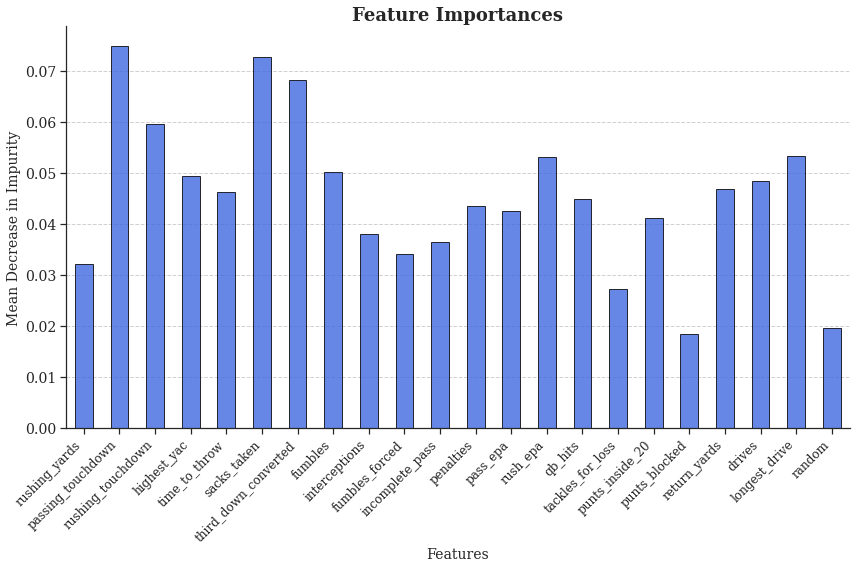

In [22]:
#add a random binary variable to a copy of the training dataset
X_train_r = X_train.copy()
X_train_r["random"] = np.random.choice([0, 1], size=len(X_train))

#initialize a random forest classifier
rf_r = RandomForestClassifier(n_estimators=400,
                                max_features=7,
                                  random_state=84,
                                  oob_score=True)

#fit the random forest model
rf_r.fit(X_train_r, y_train)

#extract feature importances from the model
forest_importances = pd.Series(rf_r.feature_importances_, index=rf_r.feature_names_in_)

#plot the feature importances to compare them visually
fig, ax = plt.subplots(figsize=(12, 8))
forest_importances.plot.bar(ax=ax, color="royalblue", edgecolor="black", alpha=0.8)
ax.set_title("Feature Importances", fontsize=18, fontweight="bold")
ax.set_ylabel("Mean Decrease in Impurity", fontsize=14)
ax.set_xlabel("Features", fontsize=14)
ax.grid(axis="y", linestyle="--", alpha=0.9)
plt.xticks(rotation=45, ha="right", fontsize=12)
ax.tick_params(axis="y", labelsize=14)
fig.tight_layout()
plt.show()

PD Numerical Features: 100%|██████████████████████| 3/3 [00:07<00:00,  2.35s/it]


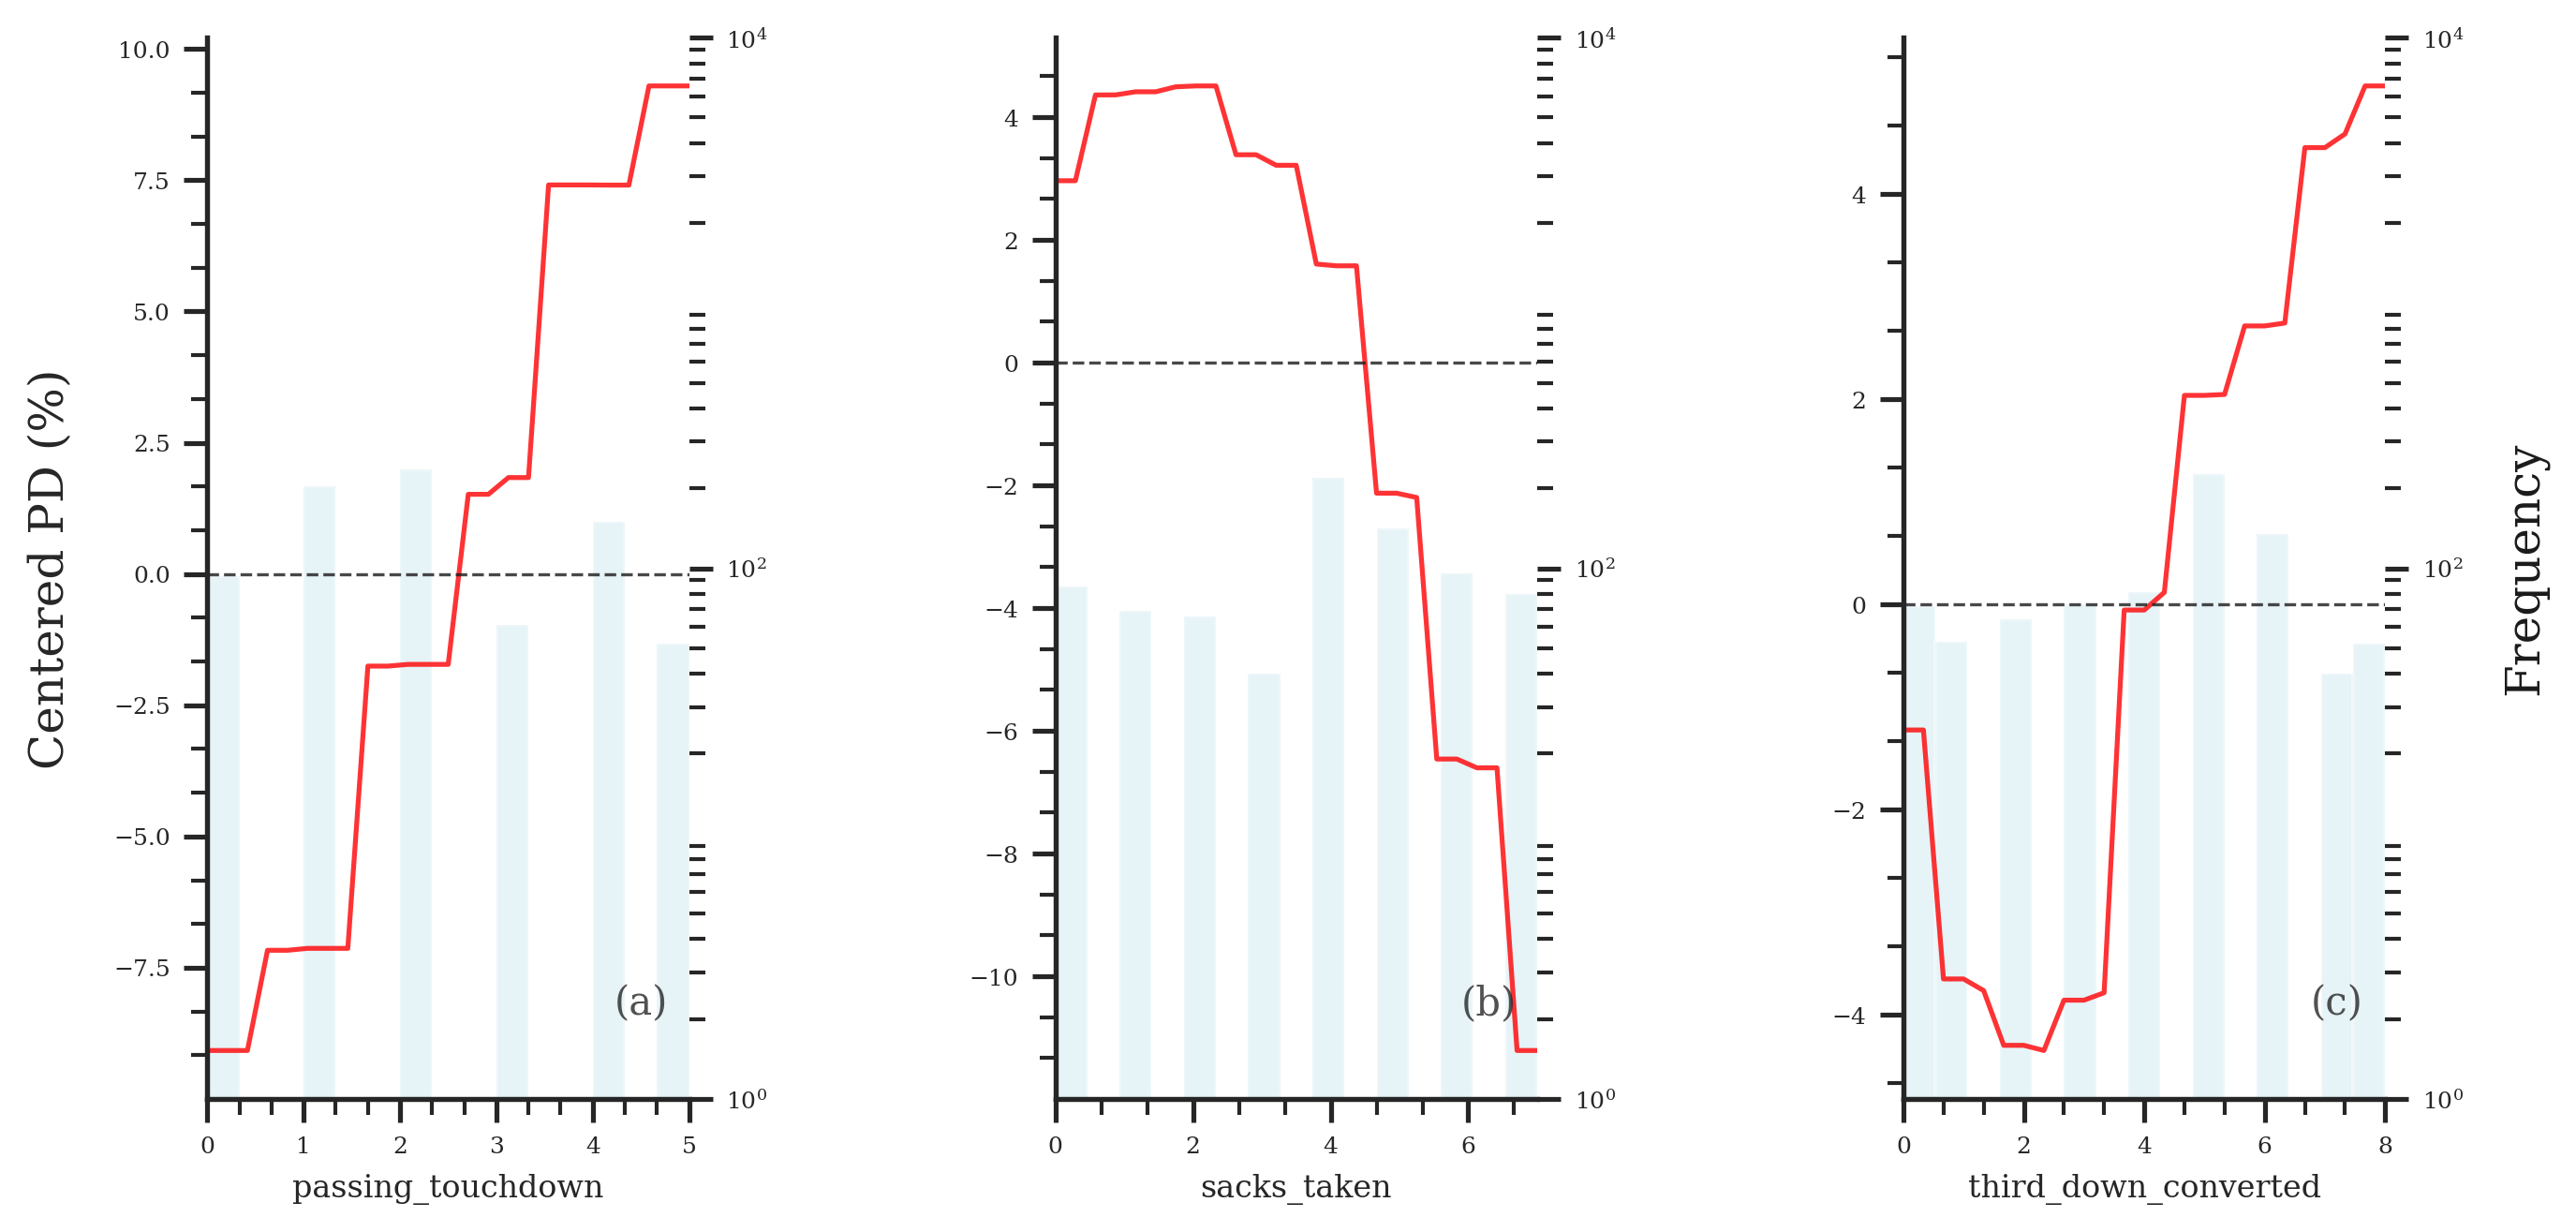

In [24]:
#initialize the explainertoolkit with random forest model
explainer = skexplain.ExplainToolkit(("Random Forest", rf), X=X_train, y=y_train)

#important features to analyze using partial dependence plots
imp_vars = ["passing_touchdown", "sacks_taken", "third_down_converted"]

#compute the partial dependence values for the selected features
pd = explainer.pd(features=imp_vars)

#generate and display the partial dependence plots
fig, axes = explainer.plot_pd(pd=pd, figsize=(10,5))
plt.show()

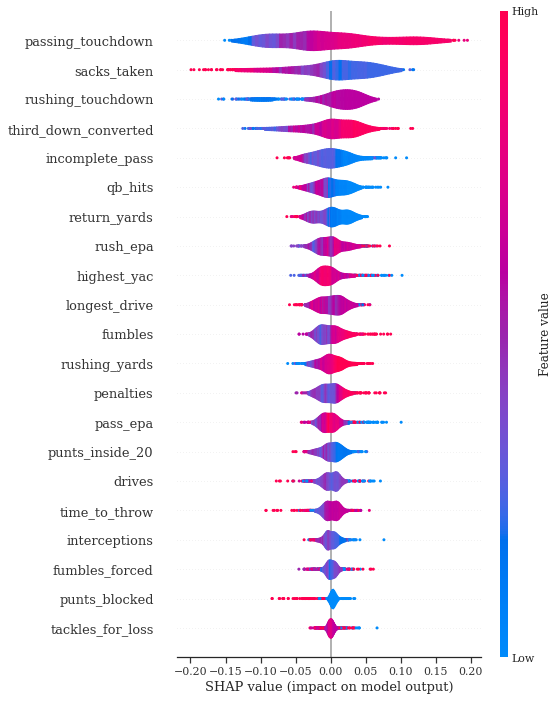

In [26]:
#create shap treeexplainer for the random forest model
explainer = shap.TreeExplainer(rf)

#compute shap values
shap_values = explainer(X_train)

#generate a violin plot for the shap values of the wins
shap.summary_plot(shap_values[:, :, 1], X_train, plot_type="violin", max_display=22)

In [48]:
#separate target and feature variables
colnames = list(test.columns[:-1])
X_test = test[colnames]
y_test = test["win"]

#add predicted probabilities for wins to test data
test["p_hat"] = rf.predict_proba(X_test)[:, 1]

#generate the false positive rate, true positive rate, and cutoffs for the roc curve
fpr, tpr, cutoffs = roc_curve(test["win"], test["p_hat"])

#create a dataframe containing the tpr, fpr, cutoffs, and youden's j statistic
data = {"TPR": tpr, "FPR": fpr, "Cut-off": cutoffs, "Youden": tpr-fpr}
youden = pd.DataFrame(data)
youden.sort_values(by="Youden", ascending=False) #highest j statistic is optimal cutoff

,TPR,FPR,Cut-off,Youden
41,0.619565,0.268519,0.535000,0.351047
40,0.608696,0.259259,0.537500,0.349436
38,0.576087,0.240741,0.547500,0.335346
47,0.663043,0.333333,0.516250,0.329710
45,0.652174,0.324074,0.517500,0.328100
...,...,...,...,...
3,0.043478,0.009259,0.760000,0.034219
2,0.032609,0.000000,0.764167,0.032609
1,0.010870,0.000000,0.802500,0.010870
0,0.000000,0.000000,1.802500,0.000000


0.6851348631239935 



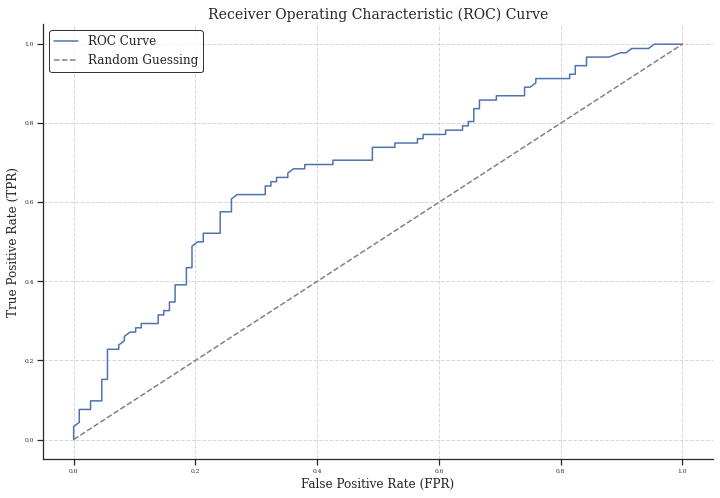

In [50]:
#print the area under the roc curve
print(auc(fpr, tpr), "\n")

#plot the roc curve
fig, ax = plt.subplots(figsize=(12, 8))
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
roc_display.plot(ax=ax, label="ROC Curve")  
ax.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guessing")
ax.set_title("Receiver Operating Characteristic (ROC) Curve", fontsize=14)
ax.set_xlabel("False Positive Rate (FPR)", fontsize=12)
ax.set_ylabel("True Positive Rate (TPR)", fontsize=12)
ax.grid(True, linestyle="--", alpha=0.75)
ax.legend(loc="upper left", fontsize=12, frameon=True, facecolor="white", edgecolor="black")
plt.show()